# Cartopy tutorial: Transforming raster to vector

Going from raster data to vector is a surprisingly common task, even though we may not always think of it in those terms.


### Contouring

Perhaps the most obvious raster to vector transformation is contouring.
A contouring algorithm takes an array of numbers, and computes routes of iso-lines or iso-surfaces.

Let's start with matplotlib's contouring routines. The isosurface implementation is available through ``plt.contourf`` (filled contours), while the isoline implementation is ``plt.contour`` (line contours):

In [1]:
import cartopy.crs as ccrs
from cartopy.examples.waves import sample_data
import matplotlib.pyplot as plt

lons, lats, data = sample_data()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(
    lons, lats, data, 5,  # Choose approximately 5 sensible levels.
    transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(orientation='horizontal')
plt.show()

<Figure size 640x480 with 2 Axes>

Let's pick out one of these contours. We could choose to pick out a line (``contour``) or a polygon (``contourf``).
Since we have already produced filled contours, let's use those:

In [2]:
print(cs.levels)
print('N levels: {}'.format(len(cs.levels)))
print('N collections: {}'.format(len(cs.collections)))

[-1.2 -0.8 -0.4  0.   0.4  0.8  1.2]
N levels: 7
N collections: 6


In [3]:
print(cs.levels[4:6])
print(cs.collections[4])
paths = cs.collections[4].get_paths()

[0.4 0.8]


We now need to convert these matplotlib Paths into Shapely geometries. The [``descartes``](https://pypi.org/project/descartes/) package is designed to do precisely this, but cartopy also has such functionality that has been tuned for performance:

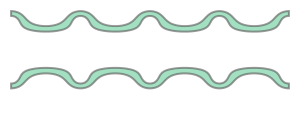

In [4]:
from cartopy.mpl.patch import path_to_geos
import shapely.ops

# Produces a list of shapely geometries.
geoms = []
for path in paths:
    geoms.extend(path_to_geos(path))

# Flatten the whole thing down to a single MultiPolygon
polygon = shapely.ops.unary_union(geoms)
polygon

We could use this geometry for any number of vector-type operations, but for now, let's just save it to disk. GeoJSON is a good choice for this kind of geometry - GeoJSON has become ubiquitous on the internet for its simpliciy and its interoperability with a number of popular tools/frameworks (including GitHub).

In [5]:
import json
import shapely.geometry as sgeom

with open('contour.geojson', 'w') as fh:
    json.dump(sgeom.mapping(polygon), fh)

We've uploaded this geojson to a GitHub gist to show how GitHub renders this file: https://gist.github.com/pelson/837ca8c01d38157a2d634dcf97260e45

Be aware that the GeoJSON specification states that geometries MUST be saved in WGS84. The default PlateCarree instance is in fact equivalent to WGS84, so in this case we didn't need to convert the geometry. If had needed to convert it we could project the geometry with ``ccrs.PlateCarree().project_geometry(geometry, source_crs)``.

### Data space vs pixel space

So far we have used ``matplotlib.contour[f]`` to produce our contours, which conveniently returns contours in *data* coordinates. Sometimes we want to use tools that don't work in coordinate space, and which simply return pixel locations.

One of the most basic examples of this is numpy's ``where`` function. Let's use that to identify the yellow sections from the Wikipedia image below:

![Wikipedia route around the world](../../resources/640px-Around_the_World_in_Eighty_Days_map.png)

In [6]:
import numpy as np
import skimage.io

# Image has shape: (y: 296, x: 640, RGBA: 4)
atw80d = skimage.io.imread(
    '../../resources/640px-Around_the_World_in_Eighty_Days_map.png')

yellowish = ((atw80d[:, :, 0] > 200) &  # Lots of Red.
             (atw80d[:, :, 1] > 200) &  # Lots of Green.
             (atw80d[:, :, 2] < 100) &  # Not lots of Blue.
             (atw80d[:, :, 3] > 250))   # Not transparent.

ind_y, ind_x = np.where(yellowish)
print('Number of yellow-ish pixels: ', len(ind_x))
print('x indexes: ', ind_x)
print('y indexes: ', ind_y)

Number of yellow-ish pixels:  17
x indexes:  [ 85  86  79  80  81  82  83  84  85  86  79  80  81  82  83 421 422]
y indexes:  [ 82  82  83  83  83  83  83  83  83  83  84  84  84  84  84 116 116]


Conversion between pixel locations and data locations is currently quite manual, but the following function will allow us to go from pixel centers to data coordinates:

In [7]:
def pixels_to_data(extent, shape, i, j):
    """Converts from coordinates of the array to data coordinates."""
    xmin, xmax, ymin, ymax = extent
    x_range = xmax - xmin
    y_range = ymax - ymin
    
    pix_width = x_range / shape[1]
    pix_height = y_range / shape[0]

    # For y handle the fact that the image's pixels
    # start at the top (in mpl that is what origin='upper' means).
    j = shape[0] - j

    return (xmin + pix_width * (i + 0.5),
            ymin + pix_height * (j + 0.5))

If we feed in the image extent and the x and y indices computed using ``np.where``, we get the pixel location in the coordinate system of the image (Robinson):

In [8]:
# Use the extents computed in an earlier exercise.
extent = [-13636707, 17044670, -6308712, 8565930]

# Note: Data coords in Robinson.
xs, ys = pixels_to_data(
    extent, atw80d.shape,
    ind_x, ind_y)

print('Last 3 x coordinates (Robinson): ', xs[-3:])
print('Last 3 y coordinates (Robinson): ', ys[-3:])

Last 3 x coordinates (Robinson):  [-9633746.09453125  6569856.13359375  6617795.78515625]
Last 3 y coordinates (Robinson):  [4369873.89527027 2761804.48986487 2761804.48986487]


Now that we have the coordinates, let's plot the pixels we have identified:

<IPython.core.display.Javascript object>


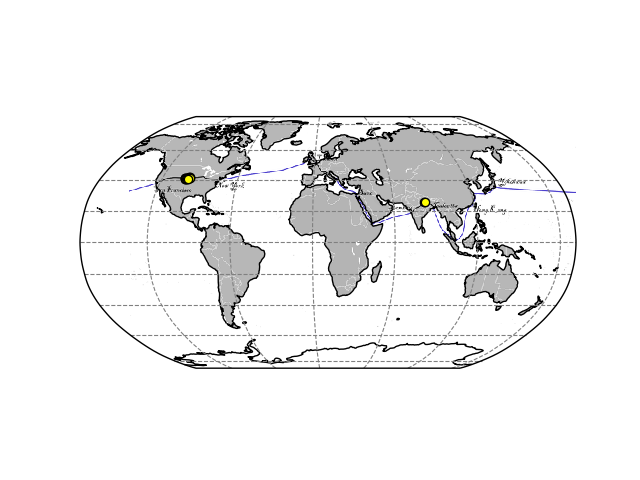

In [9]:
%matplotlib notebook
plt.figure()

rob = ccrs.Robinson(central_longitude=11.25)
ax = plt.axes(projection=rob)

ax.gridlines(color='gray', linestyle='--')
ax.coastlines()
ax.imshow(atw80d, extent=extent,
          transform=rob, origin='upper')
ax.set_global()

plt.plot(xs, ys, transform=rob,
         linestyle='none', marker='o',
         markeredgecolor='k', color='yellow')
plt.show()

Let's take this a step further and use [scikit-image](http://scikit-image.org/) to pull out the track. Let's welcome **Juan Nunez-Iglesias (@jni)** for a guest appearance to talk us through it:

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq as vector_quantization
import skimage.io


# Load the full image (not the 640px one), and scale the pixels
# between 0-1.
atw80d = skimage.io.imread(
    '../../resources/Around_the_World_in_Eighty_Days_map.png') / 255

colors = np.array(
[[1. , 1. , 1. ],  # white
 [0.7, 0.7, 0.7],  # gray
 [0. , 0. , 0. ],  # black
 [1. , 1. , 0. ],  # yellow
 [0. , 0. , 1. ]]  # blue
)
atw_nearest_color_idx, error = vector_quantization(
    atw80d.reshape((-1, 3)), colors)
atw_quantized = colors[atw_nearest_color_idx].reshape(atw80d.shape)

To confirm the quantization, let's take a look:

<IPython.core.display.Javascript object>


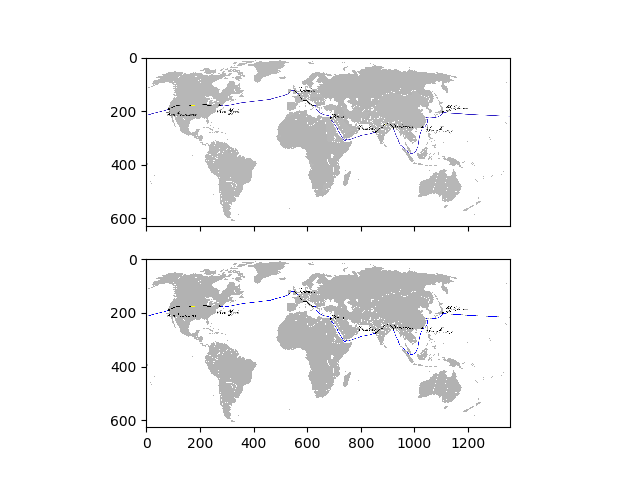

In [11]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True)
ax0.imshow(atw80d)
ax1.imshow(atw_quantized)

In [12]:
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi

# Find all the colors that don't have a zero (gray and white).
track_et_al = np.sum(atw_quantized == 0, axis=2) > 0

# Now use skimage to label the data, and only keep the longest
# track.
pixel_groups, n_groups = ndi.label(track_et_al)
group_sizes = np.bincount(pixel_groups.ravel())
track_size = np.max(group_sizes[1:])
track_fat = remove_small_objects(
    track_et_al, min_size=track_size - 1)

Next, skeletonize the image to remove the line width from the image, and finally compute the coordinates of the line.

In [13]:
from skimage.morphology import skeletonize
from itertools import product

track = skeletonize(track_fat)
point_coordinates = np.array(np.nonzero(track)).T
leftmost_idx = np.argmin(point_coordinates[:, 1])
start = point_coordinates[leftmost_idx]

# Function to walk the skeleton and extract the pixel
# coordinates of the route. If you are doing this for real, you
# might like to check out https://jni.github.io/skan/
def points_to_path(point_coordinates, start_point, track_image):
    neighbor_idxs = list(product((-1, 0, 1), (-1, 0, 1)))
    neighbor_idxs.remove((0, 0))

    not_visited = track_image.copy()
    
    path = np.zeros_like(point_coordinates)
    path[0] = start
    npoints = point_coordinates.shape[0]
    currpoint = start

    for i in range(1, npoints):
        not_visited[tuple(currpoint)] = False
        for neighbor in currpoint + neighbor_idxs:
            if not_visited[tuple(neighbor)]:
                path[i] = neighbor
                currpoint = neighbor
                break
    return path

path_coords = points_to_path(point_coordinates, start, track)

To confirm this has done what we wanted, let's look at the path on a map:

<IPython.core.display.Javascript object>


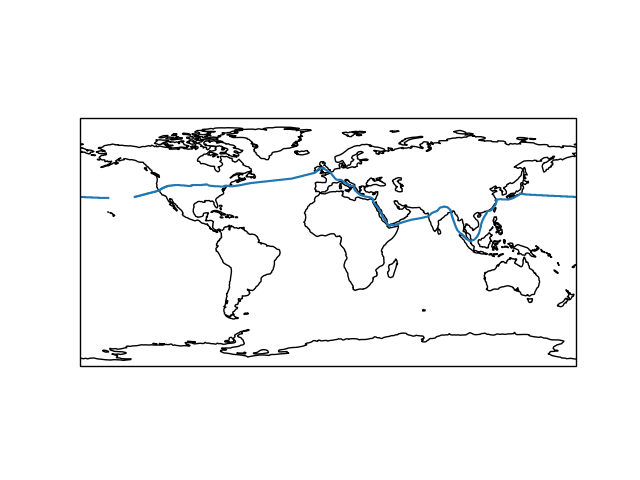

In [14]:
plt.figure()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
xs, ys = pixels_to_data(
    extent, atw80d.shape,
    path_coords[:, 1], path_coords[:, 0])

# Remember, the coordinate points are projected Robinson.
rob = ccrs.Robinson(central_longitude=11.25)
ax.plot(xs, ys, transform=rob)

ax.set_global()
plt.show()

Apart from the gap, this looks good. The gap is a genuine artifact of the original image, but is still not desirable. Let's project the geometry we have to Plate Carree and then we'll close the loop:

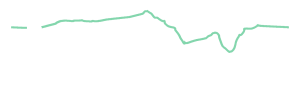

In [15]:
import shapely.geometry as sgeom

track_geom = sgeom.LineString(np.stack([xs, ys], axis=-1))

pc_track_geom = ccrs.PlateCarree().project_geometry(track_geom, rob)
pc_track_geom

From here, we can compute the endpoints nearest to each other, and construct a line between them. We can then use shapely's linemerge to join all three lines together: 

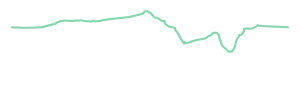

In [16]:
import shapely.ops
missing_segment = sgeom.LineString(
    shapely.ops.nearest_points(*pc_track_geom.geoms))

route = shapely.ops.linemerge(
    list(pc_track_geom.geoms) + [missing_segment])
route

**Exercise 5.1:** Now that we have projected the route to Plate Carree coordinates, draw the line (using the ``add_geometries`` method) on top of a Robinson map with coastlines.


*Extension:* Save the route geometry as a GeoJSON.

In [ ]:
# EXERCISE 5.1:



<details>
    <summary style="margin-top: 1em; margin-left: 1em;"><b>Click to show solution for 5.1</b></summary>
<pre>
plt.figure()

ax = plt.axes(projection=rob)
ax.coastlines()
ax.add_geometries(
    [route], ccrs.PlateCarree(),
    edgecolor='blue', facecolor='none', linewidth=2)
ax.set_global()
plt.show()
</pre>
</details>

In [ ]:
# EXERCISE 5.1 EXTENSION:



<details>
    <summary style="margin-top: 1em; margin-left: 1em;"><b>Click to show solution for 5.1 extension</b></summary>
<pre>
import json
import shapely.geometry as sgeom

with open('route.geojson', 'w') as fh:
    json.dump(sgeom.mapping(route), fh)
</pre>
</details>